In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
base_dir = "/kaggle/input/new-plant-diseases-datasets-2g/New Plant Diseases Datasets 2G"
image_size = 224

In [6]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                            shear_range = 0.2,
                                                            zoom_range = 0.2,
                                                            width_shift_range = 0.2,
                                                            height_shift_range = 0.2,
                                                            fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [7]:
train_data = train_datagen.flow_from_directory(os.path.join(base_dir,"train"),
                                               target_size=(image_size,image_size),
                                               batch_size=32,
                                               class_mode="categorical"                                               
                                              )

Found 35120 images belonging to 19 classes.


In [8]:
test_data = test_datagen.flow_from_directory(os.path.join(base_dir,"valid"),
                                               target_size=(image_size,image_size),
                                               batch_size=32,
                                               class_mode="categorical"                                               
                                              )

Found 8779 images belonging to 19 classes.


In [9]:
train_data.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18}

In [10]:
train_data.image_shape

(224, 224, 3)

In [11]:
base_model = keras.applications.MobileNet(weights="imagenet",
                                          input_shape=(224,224,3),
                                          include_top=False,)

17225924/17225924 [==============================] - 1s 0us/step


In [12]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [13]:
# Freeze the base_model
base_model.trainable = False

In [17]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense((19),activation="softmax")(x)

mobilenet_model = keras.Model(inputs, outputs, name='leaf_disease_model_mobilenet')
mobilenet_model.summary()

Model: "leaf_disease_model_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 19)                19475     
                                                                 
Total params: 3248339 (12.39 MB)
Train

In [18]:
mobilenet_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=[keras.metrics.CategoricalAccuracy()])

In [19]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import EarlyStopping

# EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1)

callbacks_list = [early_stop]

history = mobilenet_model.fit(train_data,
                              steps_per_epoch=300,  
                              validation_data=test_data,
                              epochs=20,
                              validation_steps=300,
                              callbacks=callbacks_list)

Epoch 1/20
300/300 [==============================] - 326s 1s/step - loss: 0.7317 - categorical_accuracy: 0.7959 - val_loss: 0.1909 - val_categorical_accuracy: 0.9500
Epoch 2/20
300/300 [==============================] - 177s 588ms/step - loss: 0.2089 - categorical_accuracy: 0.9398
Epoch 3/20
300/300 [==============================] - 174s 580ms/step - loss: 0.1473 - categorical_accuracy: 0.9556
Epoch 4/20
300/300 [==============================] - 174s 579ms/step - loss: 0.1268 - categorical_accuracy: 0.9617
Epoch 5/20
300/300 [==============================] - 170s 565ms/step - loss: 0.1056 - categorical_accuracy: 0.9658
Epoch 6/20
300/300 [==============================] - 168s 560ms/step - loss: 0.0966 - categorical_accuracy: 0.9691
Epoch 7/20
300/300 [==============================] - 168s 558ms/step - loss: 0.1005 - categorical_accuracy: 0.9669
Epoch 8/20
300/300 [==============================] - 166s 552ms/step - loss: 0.0821 - categorical_accuracy: 0.9701
Epoch 9/20
300/300 [=

In [20]:
mobilenet_model.evaluate(test_data)

275/275 [==============================] - 110s 399ms/step - loss: 0.0510 - categorical_accuracy: 0.9819


[0.051016926765441895, 0.9818885922431946]

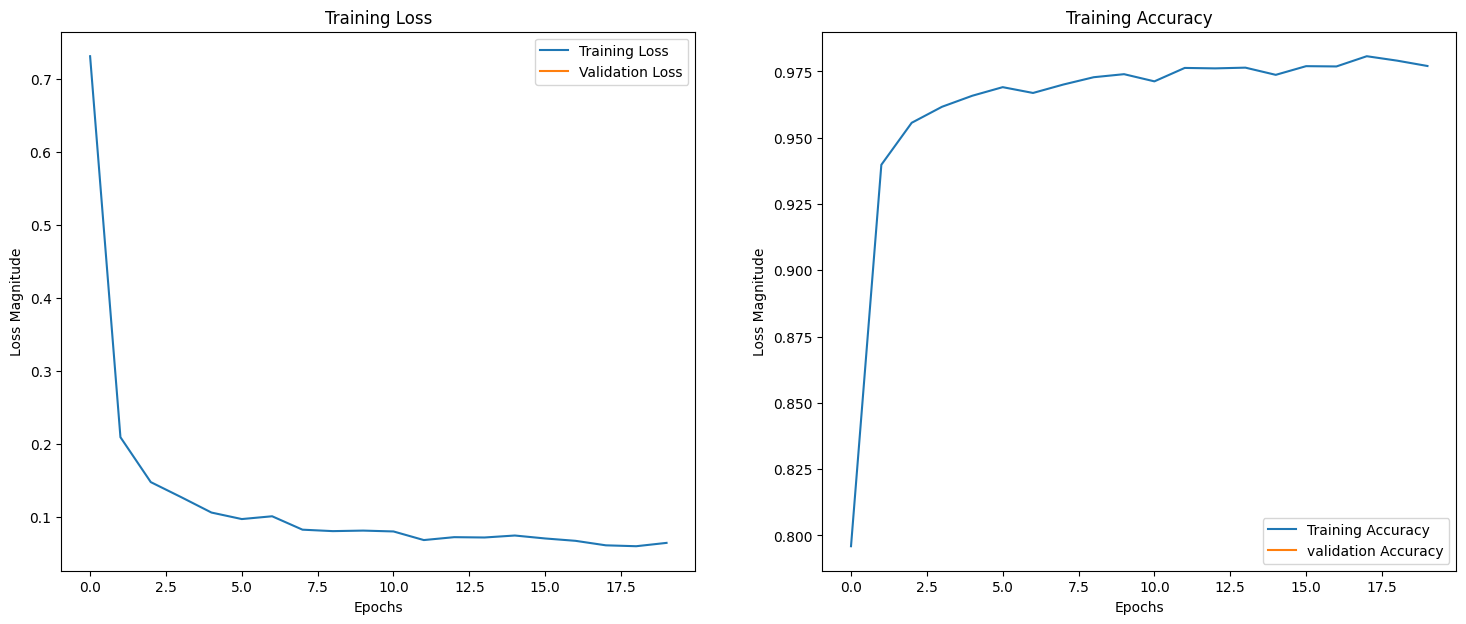

In [22]:
# Learning Curves.
# Plot Loss vs Accuracy graphs.

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.grid(False)
plt.xlabel('Epochs')
plt.ylabel('Loss Magnitude')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'validation Accuracy')
plt.grid(False)
plt.xlabel('Epochs')
plt.ylabel('Loss Magnitude')
plt.title('Training Accuracy')
plt.legend(loc='lower right')
plt.show()

275/275 [==============================] - 115s 418ms/step


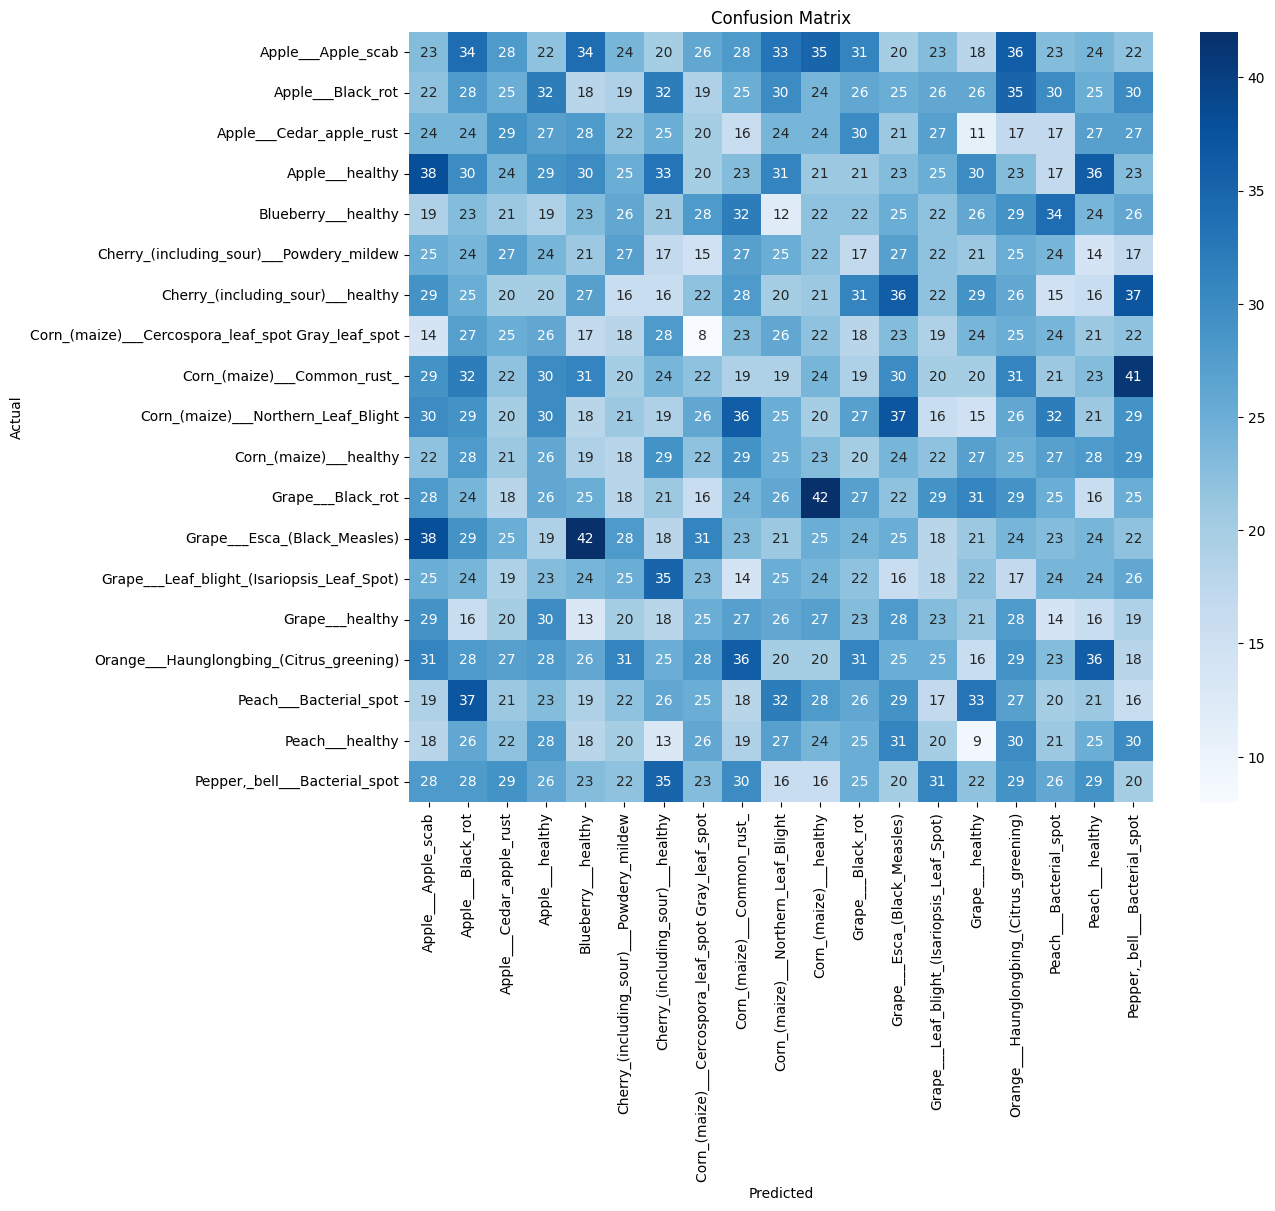

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.05      0.05      0.05       504
                                 Apple___Black_rot       0.05      0.06      0.06       497
                          Apple___Cedar_apple_rust       0.07      0.07      0.07       440
                                   Apple___healthy       0.06      0.06      0.06       502
                               Blueberry___healthy       0.05      0.05      0.05       454
          Cherry_(including_sour)___Powdery_mildew       0.06      0.06      0.06       421
                 Cherry_(including_sour)___healthy       0.04      0.04      0.04       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.02      0.02      0.02       410
                       Corn_(maize)___Common_rust_       0.04      0.04      0.04       477
               Corn_(maize)___Northern_Leaf_Blight       0.05      0.05      0.

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels for the test data
true_labels = test_data.classes  # Updated line
predicted_labels = np.argmax(mobilenet_model.predict(test_data), axis=1)

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
class_names = list(test_data.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

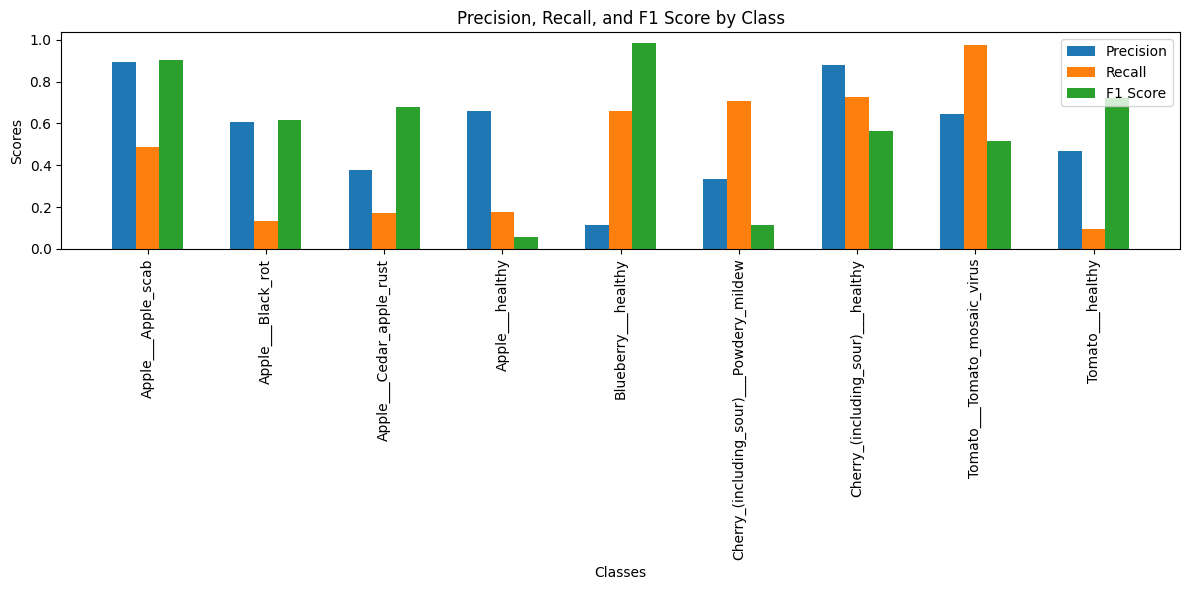

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Class names or labels
class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy','Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

# Example precision, recall, and F1-score values for each class (should match the length of class_names)
precision_values = np.random.rand(9)  # Replace this with your precision values
recall_values = np.random.rand(9)  # Replace this with your recall values
f1_score_values = np.random.rand(9)  # Replace this with your F1-score values

# Plotting precision, recall, and F1-score
fig, ax = plt.subplots(figsize=(12, 6))

index = np.arange(len(class_names))
bar_width = 0.2

rects1 = ax.bar(index, precision_values, bar_width, label='Precision')
rects2 = ax.bar(index + bar_width, recall_values, bar_width, label='Recall')
rects3 = ax.bar(index + 2 * bar_width, f1_score_values, bar_width, label='F1 Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

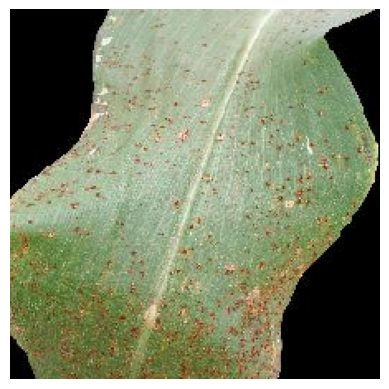

1/1 [==============================] - 0s 395ms/step
True label: Corn_(maize)___Common_rust_
Predicted label: Corn_(maize)___Common_rust_


In [25]:
def get_class_string_from_index(index):
   for class_string, class_index in test_data.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_data)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = mobilenet_model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [27]:
base_model.save_weights('model.h5')